In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
print("🌫🛸")

🌫🛸


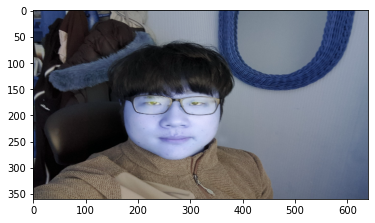

In [2]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

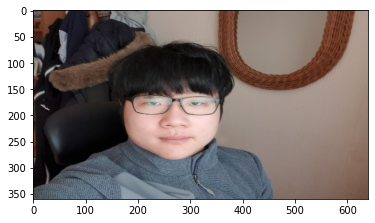

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [4]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


rectangles[[(180, 118) (366, 304)]]


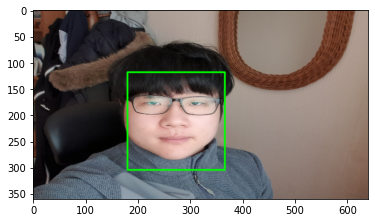

In [6]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [7]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [8]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


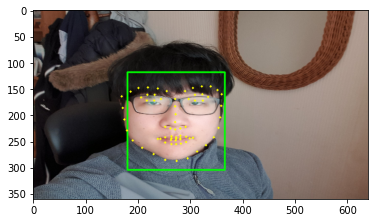

In [9]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]  #- dlib_rect.width()//2
    w = (landmark[30][0] - landmark[2][0]) *2
    #  dlib_rect.width()
    h = landmark[48][1] - landmark[36][1] 
    #dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(271, 213)
(x,y) : (271,213)
(w,h) : (194,79)


x, y 값을 연상하기 쉽도록 콧잔등(landmark[30])을 기준으로 지정,
또한 양창원님의 블로그를 참조하여 w, h 값을 변경하여 스티커 이미지 범위를 줄임

In [11]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(79, 194, 3)


In [12]:
refined_x = x - w // 2  # left
refined_y = landmark[36][1]#y - h   # top   
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (174,166)


스티커 이미지박스 좌측 상단위치를 눈꼬리(landmark[36])에 맞추기 위해 refined_y 값 지정

In [13]:
#img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(79, 194, 3)


사용되지 않는 부분이므로 주석처리

In [14]:
#refined_y = 0
#print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

사용되지 않는 부분이므로 주석처리

In [15]:
sticker_area = img_show[refined_y:refined_y+h, refined_x:refined_x+w]
img_show[refined_y:refined_y+h, refined_x:refined_x+w] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

양창원님의 블로그를 참조하여 img_show[]내부 각 값들의 의미를 학습. 상기 지정한 값들을 사용하여 area 지정.

img_sticker의 rgb값 참조하여 0은 검은색이므로 흰색인 255로 변경

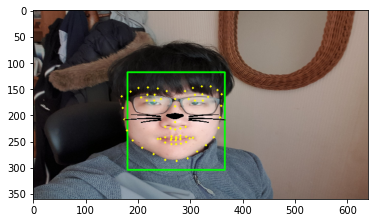

In [16]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

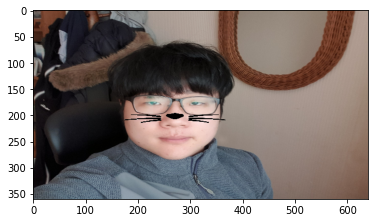

In [17]:
sticker_area = img_bgr[refined_y:refined_y+h, refined_x:refined_x+w]
img_bgr[refined_y:refined_y+h, refined_x:refined_x+w] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

이미지 크기 조절로 인한 수염 짜부현상. 그러나 결과물이 쥐 수염 느낌이나 후질구래한 몰골과 어울려 생각보다 마음에 들었으므로 추가 수정은 가하지 않음.